In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imports

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow import string as tf_string
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense, Dropout
from tensorflow.keras.layers import Embedding, Flatten

from sklearn.model_selection import train_test_split #
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_score, recall_score
from sklearn.preprocessing import normalize, OneHotEncoder
import scipy
import itertools
from sklearn.feature_extraction.text import CountVectorizer
import unicodedata, re, string
import nltk
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import LancasterStemmer


## Nacitanie

In [ ]:
dataset = pd.read_csv('../Data/final_dataset_4.csv')

## Rozdelenie dat na sady

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataset['processed_text'], dataset['author_id'], test_size=0.20, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [ ]:
print(X_train[:10])

1160    rest spiritual furniture modest scattered tend...
557     meantime widow cranfield went bustling house f...
1181    offered hand took grasp became would seen fine...
1084    long reached spot rather tall house uninhabite...
253     seeing grown one fairest maidens many valorous...
802     call multiplied cares housekeeping without sub...
1119    use try follow farther to-night thought youth ...
34      period landing clive young writer india close ...
320     rudge could leave wife daughters without retur...
790     could come nothing kindly terms went engaged d...
Name: processed_text, dtype: object


## One hot encoding

In [ ]:
one_hot_encoder = OneHotEncoder()

y_train = one_hot_encoder.fit_transform(y_train.to_numpy().reshape(-1, 1)).toarray()
y_valid = one_hot_encoder.transform(y_valid.to_numpy().reshape(-1, 1)).toarray()
y_test = one_hot_encoder.transform(y_test.to_numpy().reshape(-1, 1)).toarray()

In [ ]:
print(y_valid)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


# CountVectorizer

In [ ]:
vectorizer = CountVectorizer()
X_train_cv = vectorizer.fit_transform(X_train).toarray()
X_test_cv = vectorizer.transform(X_test).toarray()
X_valid_cv = vectorizer.transform(X_valid).toarray()


In [ ]:
y_train.shape

(871, 20)

## Model 1

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(X_train_cv.shape[1],)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.1),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.1),

    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax')
])

model.summary()

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               47798784  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [ ]:
# Train the model
history = model.fit(X_train_cv, y_train, validation_data=(X_valid_cv, y_valid), epochs=10, batch_size = 8, callbacks=[model_checkpoint_callback])

Epoch 1/10
109/109 [==============================] - 7s 32ms/step - loss: 3.9393 - accuracy: 0.1825 - val_loss: 1.9201 - val_accuracy: 0.4742
Epoch 2/10
109/109 [==============================] - 3s 30ms/step - loss: 1.7690 - accuracy: 0.5075 - val_loss: 1.1565 - val_accuracy: 0.7423
Epoch 3/10
109/109 [==============================] - 4s 38ms/step - loss: 1.0615 - accuracy: 0.7589 - val_loss: 0.7961 - val_accuracy: 0.8144
Epoch 4/10
109/109 [==============================] - 4s 40ms/step - loss: 0.7582 - accuracy: 0.8439 - val_loss: 0.4801 - val_accuracy: 0.8969
Epoch 5/10
109/109 [==============================] - 2s 18ms/step - loss: 0.4738 - accuracy: 0.9208 - val_loss: 0.5908 - val_accuracy: 0.8866
Epoch 6/10
109/109 [==============================] - 3s 32ms/step - loss: 0.4710 - accuracy: 0.9185 - val_loss: 0.3887 - val_accuracy: 0.9175
Epoch 7/10
109/109 [==============================] - 2s 18ms/step - loss: 0.1479 - accuracy: 0.9747 - val_loss: 0.4659 - val_accuracy: 0.9278

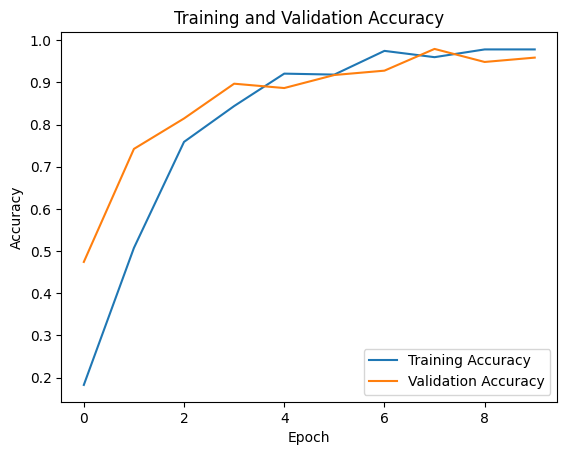

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test_cv, y_test, verbose=0)

y_pred_probs = model.predict(X_test_cv)
y_pred = np.argmax(y_pred_probs, axis=1)
y_test_indices = np.argmax(y_test, axis=1)

test_f1 = f1_score(y_test_indices, y_pred, average='macro')
test_precision = precision_score(y_test_indices, y_pred, average='macro')
test_recall = recall_score(y_test_indices, y_pred, average='macro')

print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')
print(f'Test F1 Score: {test_f1}')
print(f'Test Precision: {test_precision}')
print(f'Test Recall: {test_recall}')

8/8 [==============================] - 0s 9ms/step
Test loss: 0.2131837159395218
Test accuracy: 0.9752066135406494
Test F1 Score: 0.9737745352224374
Test Precision: 0.9779395604395604
Test Recall: 0.9723407148407149


# TextVectorization

## Model 2


In [ ]:
embedding_dim = 512
vocab_size = 90000
sequence_length = 9000

vect_layer = TextVectorization(max_tokens=vocab_size, output_mode='int', output_sequence_length=sequence_length)
vect_layer.adapt(dataset['processed_text'].values)

In [ ]:
model = tf.keras.Sequential([
    vect_layer,
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=sequence_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax')
])

model.summary()

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 9000)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 9000, 512)         46080000  
                                                                 
 global_average_pooling1d (  (None, 512)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 128)              

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=15, batch_size = 8, callbacks=[model_checkpoint_callback])

Epoch 1/15
109/109 [==============================] - 17s 132ms/step - loss: 2.8556 - accuracy: 0.0689 - val_loss: 2.7870 - val_accuracy: 0.0722
Epoch 2/15
109/109 [==============================] - 14s 130ms/step - loss: 2.4721 - accuracy: 0.1975 - val_loss: 2.2424 - val_accuracy: 0.2784
Epoch 3/15
109/109 [==============================] - 14s 131ms/step - loss: 1.8678 - accuracy: 0.3639 - val_loss: 1.7361 - val_accuracy: 0.3711
Epoch 4/15
109/109 [==============================] - 14s 130ms/step - loss: 1.3670 - accuracy: 0.5304 - val_loss: 1.2495 - val_accuracy: 0.6289
Epoch 5/15
109/109 [==============================] - 14s 125ms/step - loss: 0.9225 - accuracy: 0.7003 - val_loss: 0.9320 - val_accuracy: 0.7526
Epoch 6/15
109/109 [==============================] - 14s 126ms/step - loss: 0.6022 - accuracy: 0.8220 - val_loss: 0.7354 - val_accuracy: 0.7526
Epoch 7/15
109/109 [==============================] - 13s 123ms/step - loss: 0.3984 - accuracy: 0.8955 - val_loss: 0.6248 - val_ac

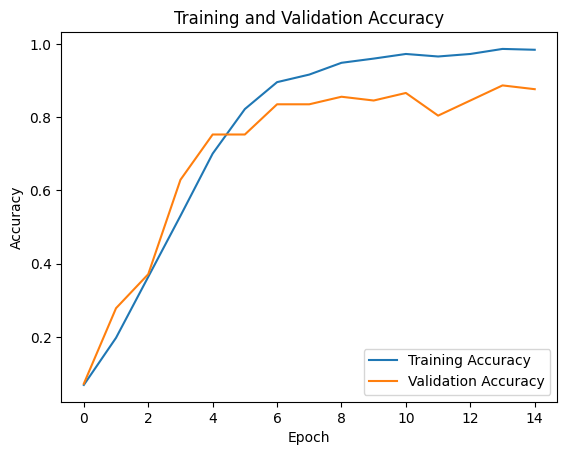

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

8/8 [==============================] - 1s 58ms/step


In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted')
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.9090909090909091
F1 Score: 0.9108494334540158
Precision: 0.9224461576435261
Recall: 0.9090909090909091


## Model 2 - vacsi vocab_site


In [ ]:
embedding_dim = 512
vocab_size = 120000
sequence_length = 9000

vect_layer = TextVectorization(max_tokens=vocab_size, output_mode='int', output_sequence_length=sequence_length)
vect_layer.adapt(dataset['processed_text'].values)

In [ ]:
model = tf.keras.Sequential([
    vect_layer,
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=sequence_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax')
])

model.summary()

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (Text  (None, 9000)              0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 9000, 512)         61440000  
                                                                 
 global_average_pooling1d_1  (None, 512)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_8 (Dense)             (None, 256)               131328    
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 128)              

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=15, batch_size = 8, callbacks=[model_checkpoint_callback])

Epoch 1/15
109/109 [==============================] - 17s 143ms/step - loss: 2.8534 - accuracy: 0.0827 - val_loss: 2.7811 - val_accuracy: 0.0928
Epoch 2/15
109/109 [==============================] - 16s 144ms/step - loss: 2.4910 - accuracy: 0.1676 - val_loss: 2.3866 - val_accuracy: 0.1649
Epoch 3/15
109/109 [==============================] - 15s 142ms/step - loss: 1.9837 - accuracy: 0.3088 - val_loss: 1.8987 - val_accuracy: 0.3608
Epoch 4/15
109/109 [==============================] - 15s 136ms/step - loss: 1.5593 - accuracy: 0.4432 - val_loss: 1.4803 - val_accuracy: 0.5464
Epoch 5/15
109/109 [==============================] - 15s 133ms/step - loss: 1.0514 - accuracy: 0.6441 - val_loss: 1.0283 - val_accuracy: 0.6289
Epoch 6/15
109/109 [==============================] - 14s 130ms/step - loss: 0.6916 - accuracy: 0.7796 - val_loss: 0.8930 - val_accuracy: 0.7216
Epoch 7/15
109/109 [==============================] - 15s 139ms/step - loss: 0.4623 - accuracy: 0.8703 - val_loss: 0.6072 - val_ac

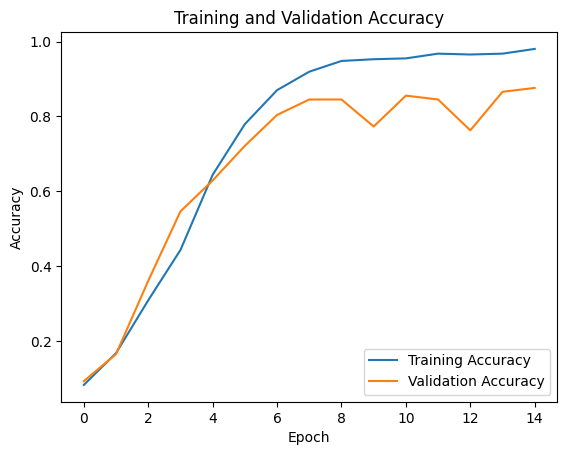

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

8/8 [==============================] - 1s 54ms/step


In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted')
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.9256198347107438
F1 Score: 0.9273847214190369
Precision: 0.9425324675324676
Recall: 0.9256198347107438
